In [1]:
#imports
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Importing the dataset

In [2]:
# Import dataset

data_dir = '../input/fruits/fruits-360'
print('Folders :', os.listdir(data_dir))

Folders : ['readme.md', 'LICENSE', 'Test', 'Training', 'test-multiple_fruits', 'papers']


# Exploring Dataset

In [3]:
classes = os.listdir(data_dir + "/Training")
print('Classes :', classes)

Classes : ['Pear Forelle', 'Dates', 'Tomato 2', 'Grape White', 'Apple Golden 2', 'Quince', 'Nut Pecan', 'Apple Pink Lady', 'Pear Stone', 'Pepper Orange', 'Cauliflower', 'Apple Crimson Snow', 'Tomato Maroon', 'Pear 2', 'Pitahaya Red', 'Avocado', 'Redcurrant', 'Tomato 1', 'Physalis', 'Potato White', 'Apple Golden 1', 'Tomato 4', 'Mangostan', 'Plum 3', 'Raspberry', 'Cherry Wax Yellow', 'Potato Sweet', 'Pear Abate', 'Tomato Cherry Red', 'Banana', 'Strawberry Wedge', 'Cantaloupe 1', 'Huckleberry', 'Tomato Heart', 'Salak', 'Kaki', 'Cherry Wax Black', 'Passion Fruit', 'Chestnut', 'Apple Red 3', 'Grape White 2', 'Grape White 3', 'Pear Monster', 'Peach', 'Papaya', 'Apple Red 1', 'Physalis with Husk', 'Banana Lady Finger', 'Lychee', 'Cucumber Ripe 2', 'Walnut', 'Pepino', 'Potato Red Washed', 'Grapefruit Pink', 'Lemon', 'Pear Red', 'Avocado ripe', 'Plum 2', 'Kumquats', 'Apricot', 'Grapefruit White', 'Cactus fruit', 'Tomato 3', 'Kiwi', 'Kohlrabi', 'Cherry Wax Red', 'Cherry 1', 'Apple Golden 3', 'H

In [4]:
len(classes)

131

In [5]:
dataset = ImageFolder(data_dir + '/Training', transform=ToTensor())
print('Size of training dataset :', len(dataset))

Size of training dataset : 67692


In [6]:
test = ImageFolder(data_dir + '/Test', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of test dataset : 22688


In [7]:
img, label= dataset[0]
img.shape

torch.Size([3, 100, 100])

image size = 3x100x100

In [8]:
def show_example(img, label):
    print('Label: ', dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))
    


Label:  Apple Braeburn


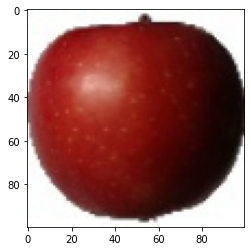

In [9]:
img,label = dataset[10]
show_example(img,label)

Label:  Apple Golden 1


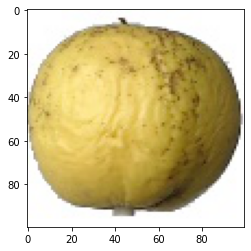

In [10]:
img,label = dataset[1001]
show_example(img,label)

Label:  Grape White 4


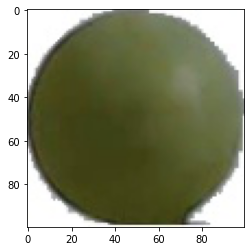

In [11]:
img,label = dataset[25000]
show_example(img,label)

Label:  Physalis


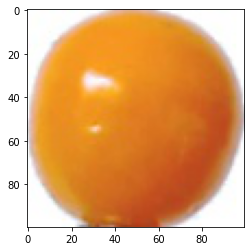

In [12]:
img,label = dataset[50000]
show_example(img,label)

# Defining batch size

In [13]:
batch_size=128

# Defining training and validation data

In [14]:
torch.manual_seed(43)
val_size = 7000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(60692, 7000)

In [15]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

# Visualizing data

shape of images: torch.Size([128, 3, 100, 100])


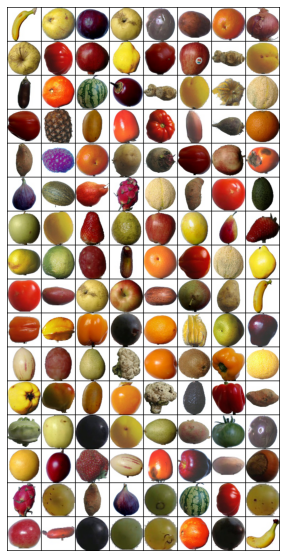

In [16]:
for images, _ in train_loader:
    print('shape of images:', images.shape)
    plt.figure(figsize=(16,10))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

# Building The Model

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [19]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
torch.cuda.is_available()

True

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [22]:
device = get_default_device()
device

device(type='cuda')

In [23]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# Training Model

In [25]:
input_size = 3*100*100
output_size = 131

In [26]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [27]:
model = to_device(Model(input_size, output_size), device)

In [28]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 4.875396728515625, 'val_acc': 0.007381290663033724}]

# Tuning Hyperparameters

In [29]:
history += fit(3, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 3.4474, val_acc: 0.1465
Epoch [1], val_loss: 1.9044, val_acc: 0.4297
Epoch [2], val_loss: 0.7097, val_acc: 0.7799


In [30]:
history += fit(3, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1744, val_acc: 0.9511
Epoch [1], val_loss: 0.1315, val_acc: 0.9622
Epoch [2], val_loss: 0.0994, val_acc: 0.9730


# Plotting Graphs


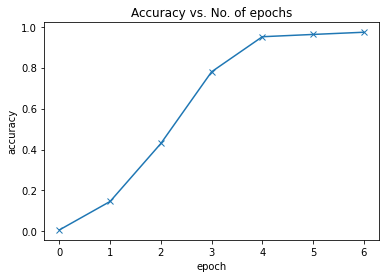

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

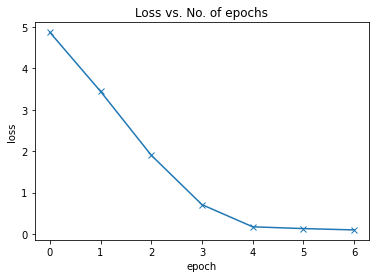

In [32]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
plot_losses(history)


# Evaluating Model On Test Data

In [40]:
evaluate(model, test_loader)

{'val_loss': 0.6336107850074768, 'val_acc': 0.8477088809013367}

In [43]:
!pip install jovian --upgrade --quiet
import jovian
jovian.commit(project="fruit_360_project", environment=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/imakshit/fruit_360_project


<IPython.core.display.Javascript object>

In [ ]:
jovian.reset()
jovian.log_hyperparams(batch_size=batch_size, learning_rate=0.001)